In [1]:
import pandas as pd

file_path = r"C:\Users\andre\Downloads\XLSDataset4470.xlsx"
df = pd.read_excel(file_path)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None) 

df.head()

,id,title,SUMMARY,TggedL1,TaggedL2
0,200361855,Two Workers Are Struck By Motor Vehicle And One Is Killed,On August 27 2013 Employees #1 and #2 of Templar Inc. a construction company specializing in fiber optic installation and services were working along a highway. The highway speed limit was posted at 55 miles per hour. Employee #1 was marking the location of an underground line that ran below the turn lane. Employee #2 was next to Employee #1 and performing the duties of a flagger. A privately owned vehicle was travelling in the travel/through lane. The vehicle veered to the right entered the turn lane and struck both workers. Emergency medical services were called. Employee #1 was declared dead at the scene. Employee #2 refused emergency medical treatment for the bruises he received when struck.,2 TRANSPORTATION INCIDENTS,26 Roadway incidents involving motorized land vehicle
1,202673471,Foreman Is Fatally Crushed When Forklift Tips Over,At approximately 6:30 a.m. on May 13 2013 Employee #1 a foreman regularly employed by Integrity Rebar Placers was operating a rough terrain forklift at a contracted job site in Murrieta CA. He was using the forklift to move bundles of steel. Employee #1 was positioning the forklift to pick up another load when the forklift tipped back and over. Employee #1 exited the cab of the forklift as the machine tipped over. The forklift fell on top of Employee #1 pinning him under the lower section of the boom and crushing his abdomen. He was killed. The employer notified Cal/OSHA of this fatality at approximately 8:35 a.m. on May 13 2013. The subsequent investigation determined that Employee #1 had been employed by the company for approximately 2.5 months.,6 CONTACT WITH OBJECTS AND EQUIPMENT,64 Caught in or compressed by equipment or objects
2,202509832,Employee Suffers Abdominal Fracture In Fall From Ladder,On April 9 2013 Employee #1 was installing vinyl sidings on a single story residence. The employee was standing an A-frame ladder that was set on a plank of a scaffold. The scaffold moved causing Employee #1 to lose his balance. The employee fell from the ladder approximately 12-ft to the ground. Employee #1 was transported to an area hospital where he was treated for an abdominal fracture. The employee remained hospitalized.,"4 FALLS,SLIPS,TRIPS",43 Falls to lower level
3,201562840,Employee'S Body Is Caught In Asphalt Machine Dies,On November 27 2012 Employee #1 was operating an asphalt-pulverizing machine. The employee's work clothing zipper was caught in the asphalt-pulverizing machine pulling his body into the squeeze point action of the machine. Employee #1 was amputated from the abdominal point of his body. The employee was pronounced dead at the scene.,6 CONTACT WITH OBJECTS AND EQUIPMENT,64 Caught in or compressed by equipment or objects
4,202478632,Employee Is Punctured In Abdomen With Nail,At approximately 11:57 a.m. on September 28 2012 Employee #1 was working with a coworker. Their job was to replace the felt under the concrete tile at the residential location. Once the felt was replaced the employees would put the tile back into place. Employee #1 removed debris from a roof and dumping leftover roof tile into a dumpster on the ground. His coworker the foreman was using a Bostitch nail gun (Model Number F21PL Serial Number 12194029B) to insert nails into roofing tiles. After the felt was replaced the employees would put the tile back in place. While walking on the pitch of the roof Employee #1 was carrying a load of leftover tile when he slipped and fell into his coworker. The coworker tried to catch Employee #1 but the nail gun went off sending a nail into Employee #1's abdomen. Employee #1 was transported to a medical center where he underwent surgical procedures and was hospitalized for postoperative care.,6 CONTACT WITH OBJECTS AND EQUIPMENT,62 Struck by object or equipment


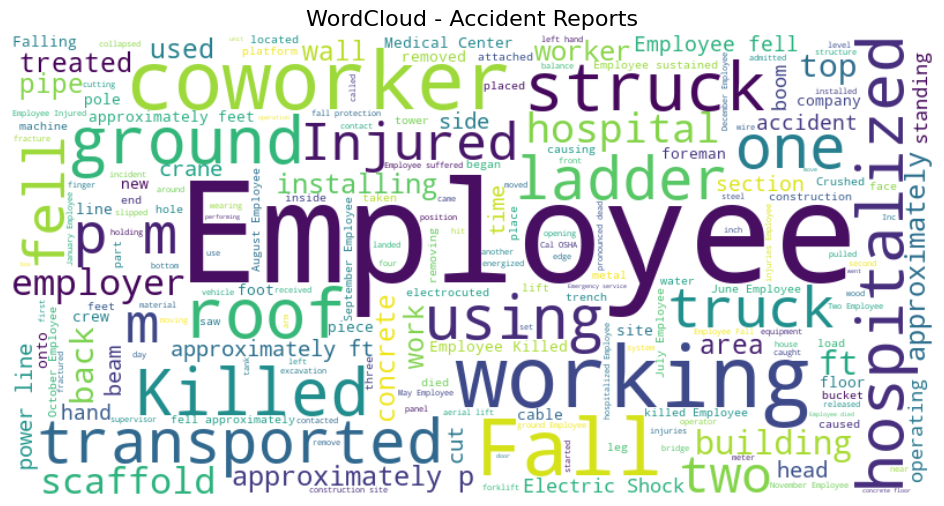

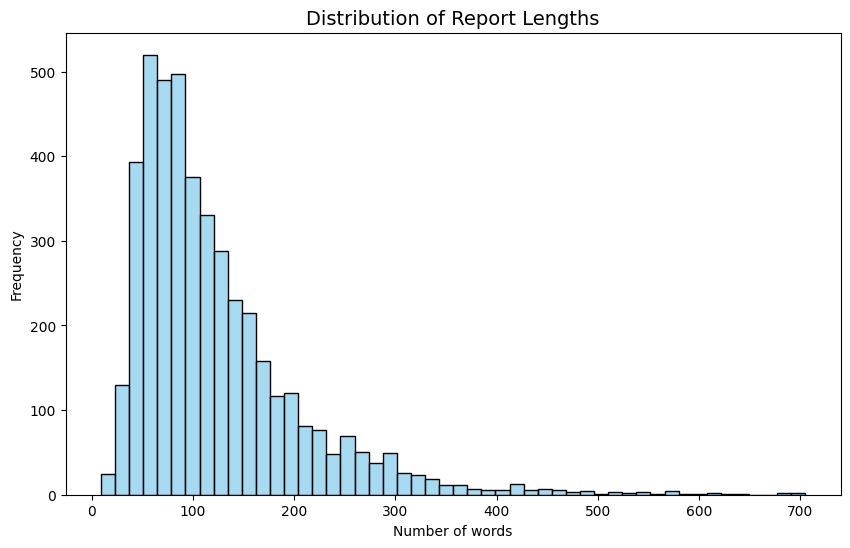

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

file_path = r"C:\Users\andre\Downloads\XLSDataset4470.xlsx"
df = pd.read_excel(file_path)

df = df.dropna(subset=['SUMMARY', 'TggedL1', 'title'])

df['report'] = df['title'].astype(str) + ' ' + df['SUMMARY'].astype(str)

# === WORDCLOUD ===
text_all = ' '.join(df['report'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_all)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Accident Reports', fontsize=16)
plt.show()

# === DISTRIBUTION OF REPORT LENGTHS ===
df['word_count'] = df['report'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=False, color='skyblue')
plt.title('Distribution of Report Lengths', fontsize=14)
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()


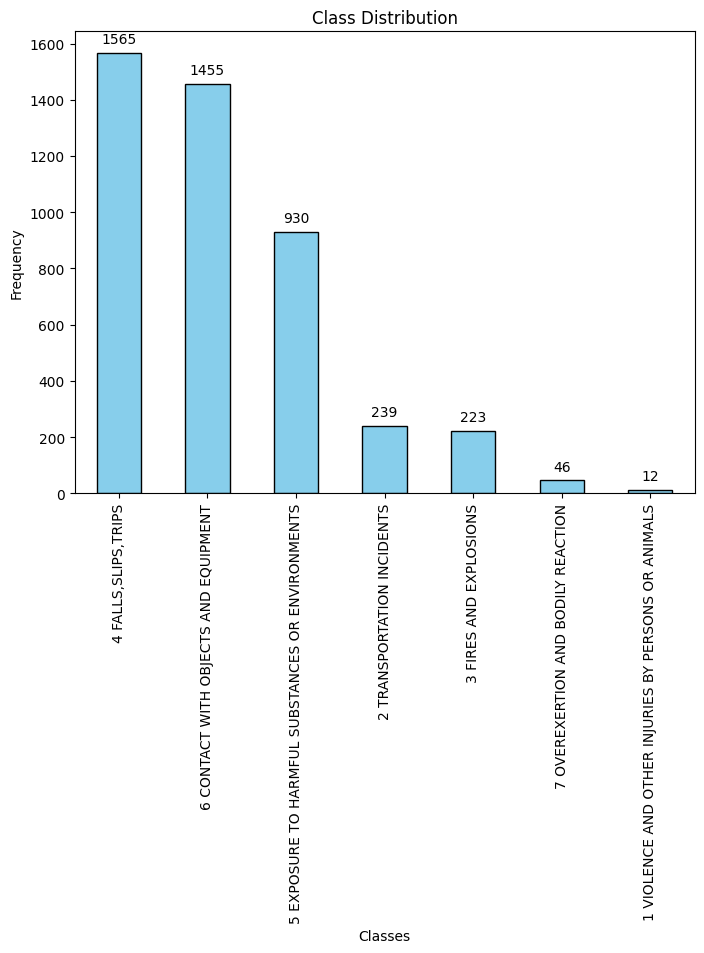

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
ax = df['TggedL1'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 10), textcoords='offset points')

plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')

plt.xticks(rotation=90)

plt.show()


In [12]:
X = df['report']
y = df['TggedL1']

In [13]:
from sklearn.model_selection import train_test_split

# --- SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
from utils import WCTfidfVectorizer, TextPreprocessor, Word2VecTransformer

corpus = [text.split() for text in X]

w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, sg=1)

In [24]:
import warnings
from sklearn.exceptions import ConvergenceWarning
import numpy as np

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Linear SVM": SVC(kernel='linear', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(), 
    "MultinomialNB": MultinomialNB() 
}

scoring = {
    'fscore': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')
}

vectorizers = {
    'tfidf': WCTfidfVectorizer(total_features=1000),
    'word2vec': Word2VecTransformer(model=w2v_model)
}

param_grids = {
    "Random Forest": {'classifier__n_estimators': [100, 200]},
    "Logistic Regression": {'classifier__C': [0.1, 1, 10], 'classifier__solver': ['liblinear', 'saga'], 'classifier__max_iter': [100, 300, 1000]},
    "Linear SVM": {'classifier__C': [0.1, 1, 10]},
    "XGBoost": {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [3, 6, 10]},
    "Bagging": {'classifier__n_estimators': [10, 50]},
    "Decision Tree": {'classifier__max_depth': [None, 10, 20]},
    "KNN": {'classifier__n_neighbors': [3, 5, 7]},
    "MultinomialNB": {'classifier__alpha': [0.1, 1.0]}
}

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_results = {}

for vector_name, vectorizer in vectorizers.items():
    print(f"\n--- Vectorizer: {vector_name} ---")

    models_to_use = models.copy()
    if vector_name == "word2vec":
        models_to_use.pop("MultinomialNB", None)

    for model_name, model in models_to_use.items():
        print(f"\n--- Model: {model_name} ---")

        steps = [
            ('preprocessing', TextPreprocessor()), 
            ('vectorizer', vectorizer),
            ('smote', SMOTE(random_state=42, k_neighbors=3)),
            ('classifier', model)
        ]

        pipe = Pipeline(steps)
        param_grid = param_grids.get(model_name, {})

        grid = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring='f1_weighted', n_jobs=1)

        target = y_train_encoded if model_name == "XGBoost" else y_train

        results = cross_validate(grid, X_train, target, cv=outer_cv,
                                 scoring=scoring, return_estimator=True, n_jobs=1)

        mean_accuracy = np.mean(results['test_accuracy'])
        mean_fscore = np.mean(results['test_fscore'])
        mean_precision = np.mean(results['test_precision'])
        mean_recall = np.mean(results['test_recall'])

        print(f"Mean Accuracy: {mean_accuracy:.3f}")
        print(f"Mean F1-score: {mean_fscore:.3f}")
        print(f"Mean Precision: {mean_precision:.3f}")
        print(f"Mean Recall: {mean_recall:.3f}")

        best_index = np.argmax(results['test_fscore'])
        best_estimator = results['estimator'][best_index]
        best_params = best_estimator.best_params_

        print(f"Best params (fold {best_index + 1}): {best_params}")

        # Salva i risultati per uso futuro
        all_results[(vector_name, model_name)] = {
            'results': results,
            'mean_accuracy': mean_accuracy,
            'mean_fscore': mean_fscore,
            'mean_precision': mean_precision,
            'mean_recall': mean_recall,
            'best_params': best_params
        }



--- Vectorizer: tfidf ---

--- Model: Random Forest ---
Mean Accuracy: 0.883
Mean F1-score: 0.879
Mean Precision: 0.881
Mean Recall: 0.883
Best params (fold 1): {'classifier__n_estimators': 100}

--- Model: Logistic Regression ---
Mean Accuracy: 0.903
Mean F1-score: 0.903
Mean Precision: 0.905
Mean Recall: 0.903
Best params (fold 1): {'classifier__C': 1, 'classifier__max_iter': 100, 'classifier__solver': 'saga'}

--- Model: Linear SVM ---
Mean Accuracy: 0.901
Mean F1-score: 0.901
Mean Precision: 0.903
Mean Recall: 0.901
Best params (fold 2): {'classifier__C': 1}

--- Model: XGBoost ---
Mean Accuracy: 0.891
Mean F1-score: 0.889
Mean Precision: 0.890
Mean Recall: 0.891
Best params (fold 1): {'classifier__max_depth': 3, 'classifier__n_estimators': 200}

--- Model: Bagging ---
Mean Accuracy: 0.824
Mean F1-score: 0.829
Mean Precision: 0.837
Mean Recall: 0.824
Best params (fold 1): {'classifier__n_estimators': 50}

--- Model: Decision Tree ---
Mean Accuracy: 0.794
Mean F1-score: 0.798
Mean 

In [34]:
for (vector_name, model_name), metrics in all_results.items():
    res = metrics['results']
    
    std_accuracy = np.std(res['test_accuracy'])
    std_fscore = np.std(res['test_fscore'])
    std_precision = np.std(res['test_precision'])
    std_recall = np.std(res['test_recall'])
    
    metrics['std_accuracy'] = std_accuracy
    metrics['std_fscore'] = std_fscore
    metrics['std_precision'] = std_precision
    metrics['std_recall'] = std_recall

    print(f"\n=== Model: {model_name} | Vectorizer: {vector_name} ===")
    print(f"Accuracy      : {metrics['mean_accuracy']:.3f} ± {metrics['std_accuracy']:.3f}")
    print(f"F1-score      : {metrics['mean_fscore']:.3f} ± {metrics['std_fscore']:.3f}")
    print(f"Precision     : {metrics['mean_precision']:.3f} ± {metrics['std_precision']:.3f}")
    print(f"Recall        : {metrics['mean_recall']:.3f} ± {metrics['std_recall']:.3f}")
    print(f"Best Params   : {metrics['best_params']}")



=== Model: Random Forest | Vectorizer: tfidf ===
Accuracy      : 0.883 ± 0.007
F1-score      : 0.879 ± 0.007
Precision     : 0.881 ± 0.008
Recall        : 0.883 ± 0.007
Best Params   : {'classifier__n_estimators': 100}

=== Model: Logistic Regression | Vectorizer: tfidf ===
Accuracy      : 0.903 ± 0.007
F1-score      : 0.903 ± 0.007
Precision     : 0.905 ± 0.007
Recall        : 0.903 ± 0.007
Best Params   : {'classifier__C': 1, 'classifier__max_iter': 100, 'classifier__solver': 'saga'}

=== Model: Linear SVM | Vectorizer: tfidf ===
Accuracy      : 0.901 ± 0.008
F1-score      : 0.901 ± 0.008
Precision     : 0.903 ± 0.006
Recall        : 0.901 ± 0.008
Best Params   : {'classifier__C': 1}

=== Model: XGBoost | Vectorizer: tfidf ===
Accuracy      : 0.891 ± 0.006
F1-score      : 0.889 ± 0.006
Precision     : 0.890 ± 0.006
Recall        : 0.891 ± 0.006
Best Params   : {'classifier__max_depth': 3, 'classifier__n_estimators': 200}

=== Model: Bagging | Vectorizer: tfidf ===
Accuracy      : 0.

In [36]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import f1_score, accuracy_score, make_scorer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

results_storage = {}

models = {
    "Logistic Regression wctfidf": LogisticRegression(random_state=42, C=1, max_iter=100, solver='saga'),
    "Linear SVM w2v": SVC(kernel='linear', C=10, random_state=42),
    "Linear SVM wctfidf": SVC(kernel='linear', C=1, random_state=42),
}

model_vectorizer_map = {
    "Logistic Regression wctfidf": 'tfidf',
    "Linear SVM w2v": 'word2vec',
    "Linear SVM wctfidf": 'tfidf',
}

vectorizers = {
    'tfidf': WCTfidfVectorizer(total_features=1000),
    'word2vec': Word2VecTransformer(model=w2v_model)
}

repeated_skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=6, random_state=42)

scoring = {
    'fscore': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score),
}

for model_name, model in models.items():
    vec_name = model_vectorizer_map[model_name]
    vectorizer = vectorizers[vec_name]
    print(f"\n--- Model: {model_name} using vectorizer: {vec_name} ---")
    
    steps = [
        ('preprocessing', TextPreprocessor()),
        ('vectorizer', vectorizer),
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', model)
    ]
    pipe = Pipeline(steps)

    results = cross_validate(pipe,
                             X_train,
                             y_train,
                             scoring=scoring,
                             return_estimator=True,
                             cv=repeated_skf,
                             n_jobs=1)

    results_storage[model_name] = {
        'accuracy': results['test_accuracy'],
        'fscore': results['test_fscore']
    }

    mean_acc = np.mean(results['test_accuracy'])
    std_acc = np.std(results['test_accuracy'])
    mean_f1 = np.mean(results['test_fscore'])
    std_f1 = np.std(results['test_fscore'])

    print(f"Accuracy: {mean_acc:.3f} ± {std_acc:.3f}")
    print(f"F1-score weighted: {mean_f1:.3f} ± {std_f1:.3f}")



--- Model: Logistic Regression wctfidf using vectorizer: tfidf ---
Accuracy: 0.898 ± 0.011
F1-score weighted: 0.899 ± 0.011

--- Model: Linear SVM w2v using vectorizer: word2vec ---
Accuracy: 0.814 ± 0.014
F1-score weighted: 0.821 ± 0.013

--- Model: Linear SVM wctfidf using vectorizer: tfidf ---
Accuracy: 0.901 ± 0.009
F1-score weighted: 0.901 ± 0.009


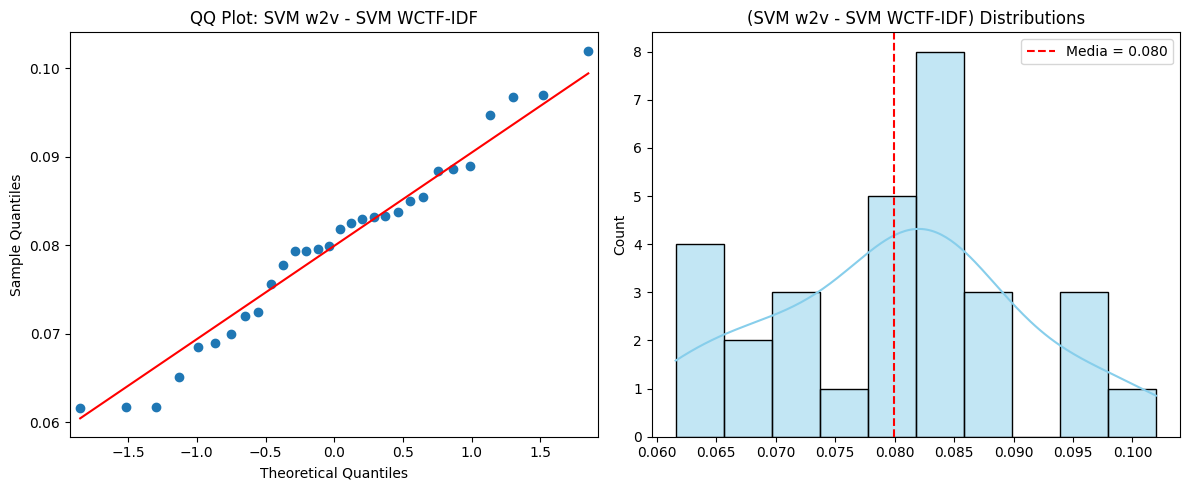

In [42]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import numpy as np

f1_svm_tfidf = results_storage['Linear SVM wctfidf']['fscore']
f1_svm_w2v = results_storage['Linear SVM w2v']['fscore']

diff_svm = f1_svm_tfidf - f1_svm_w2v

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sm.qqplot(diff_svm, line='s', ax=axs[0])
axs[0].set_title('QQ Plot: SVM w2v - SVM WCTF-IDF')

sns.histplot(diff_svm, kde=True, ax=axs[1], bins=10, color='skyblue')
axs[1].axvline(np.mean(diff_svm), color='red', linestyle='--', label=f"Media = {np.mean(diff_svm):.3f}")
axs[1].set_title('(SVM w2v - SVM WCTF-IDF) Distributions')
axs[1].legend()

plt.tight_layout()
plt.show()

In [9]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(f1_svm_tfidf, f1_svm_w2v, zero_method='wilcox', alternative='two-sided')

print(f"Wilcoxon statistic: {stat:.4f}")
print(f"P-value: {p:.10f}")

if p < 0.05:
    print("Statistical Difference (p < 0.05)")
else:
    print("No statistical difference (p ≥ 0.05)")



Wilcoxon statistic: 0.0000 
P-value: 0.0000000019 
Statistical Difference(p < 0.05)


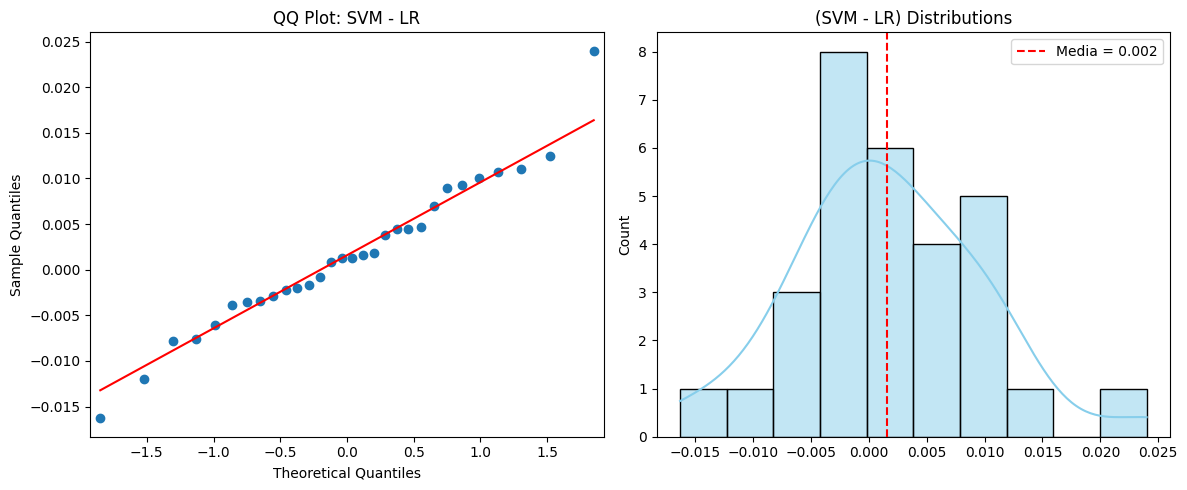

In [50]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import numpy as np

f1_svm = results_storage['Linear SVM wctfidf']['fscore']
f1_lr = results_storage['Logistic Regression wctfidf']['fscore']

diff_svm_rf = f1_svm - f1_lr

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sm.qqplot(diff_svm_rf, line='s', ax=axs[0])
axs[0].set_title('QQ Plot: SVM - LR')

sns.histplot(diff_svm_rf, kde=True, ax=axs[1], bins=10, color='skyblue')
axs[1].axvline(np.mean(diff_svm_rf), color='red', linestyle='--', label=f"Media = {np.mean(diff_svm_rf):.3f}")
axs[1].set_title('(SVM - LR) Distributions')
axs[1].legend()

plt.tight_layout()
plt.show()

In [3]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(f1_svm, f1_lr, zero_method='wilcox', alternative='two-sided')

print(f"Wilcoxon statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")

if p < 0.05:
    print("Statistical Difference between SVM e LR (p < 0.05)")
else:
    print("No statistical difference (p ≥ 0.05)")


Wilcoxon statistic: 187.0000
P-value: 0.3599
No statistical difference (p ≥ 0.05)


Accuracy: 0.903
F1-score (macro): 0.835
F1-score (weighted): 0.903

Classification Report:

                                                     precision    recall  f1-score   support

1 VIOLENCE AND OTHER INJURIES BY PERSONS OR ANIMALS       1.00      0.50      0.67         4
                         2 TRANSPORTATION INCIDENTS       0.70      0.76      0.73        72
                             3 FIRES AND EXPLOSIONS       0.91      0.94      0.93        67
                                4 FALLS,SLIPS,TRIPS       0.95      0.92      0.93       469
   5 EXPOSURE TO HARMFUL SUBSTANCES OR ENVIRONMENTS       0.93      0.95      0.94       279
               6 CONTACT WITH OBJECTS AND EQUIPMENT       0.88      0.88      0.88       436
                 7 OVEREXERTION AND BODILY REACTION       0.83      0.71      0.77        14

                                           accuracy                           0.90      1341
                                          macro avg       0.89      0

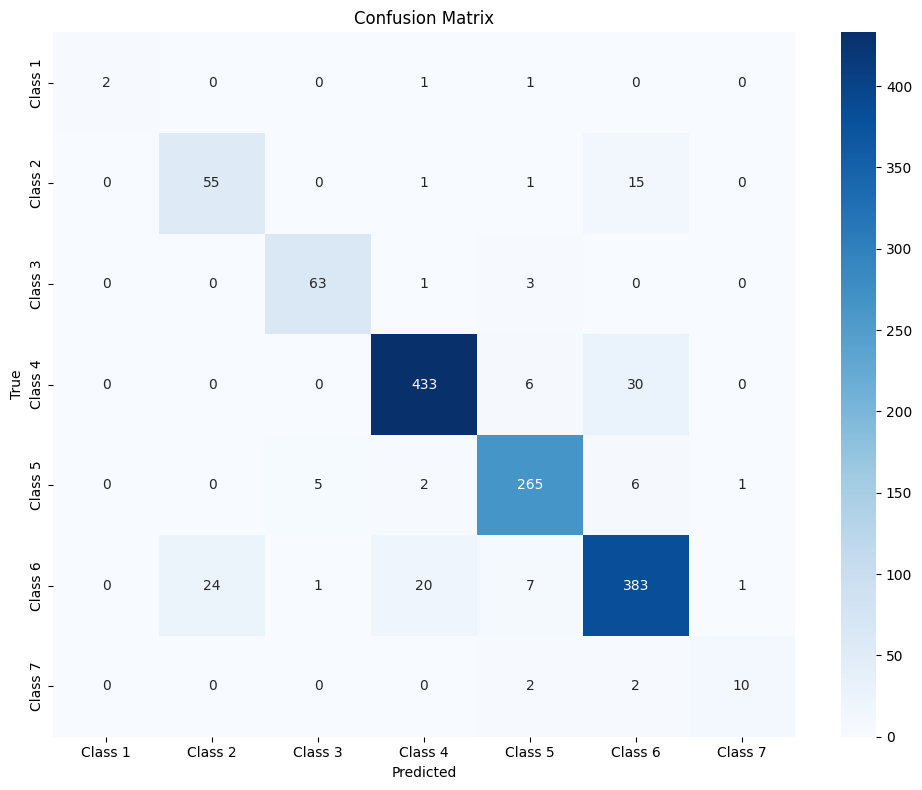

In [19]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from utils import WCTfidfVectorizer, TextPreprocessor, print_classification_report_matrix
from sklearn.svm import SVC

svm_pipe = Pipeline([
    ('preprocessing', TextPreprocessor()),
    ('tfidf', WCTfidfVectorizer(total_features=1000)),
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('svm', SVC(kernel='linear', C=1, random_state=42))
])

svm_pipe.fit(X_train, y_train)
y_pred = svm_pipe.predict(X_test)

print_classification_report_matrix(y_test, y_pred)




Accuracy: 0.906
F1-score (macro): 0.856
F1-score (weighted): 0.906

Classification Report:

                                                     precision    recall  f1-score   support

1 VIOLENCE AND OTHER INJURIES BY PERSONS OR ANIMALS       1.00      0.75      0.86         4
                         2 TRANSPORTATION INCIDENTS       0.74      0.74      0.74        72
                             3 FIRES AND EXPLOSIONS       0.91      0.94      0.93        67
                                4 FALLS,SLIPS,TRIPS       0.93      0.93      0.93       469
   5 EXPOSURE TO HARMFUL SUBSTANCES OR ENVIRONMENTS       0.93      0.95      0.94       279
               6 CONTACT WITH OBJECTS AND EQUIPMENT       0.90      0.88      0.89       436
                 7 OVEREXERTION AND BODILY REACTION       0.71      0.71      0.71        14

                                           accuracy                           0.91      1341
                                          macro avg       0.87      0

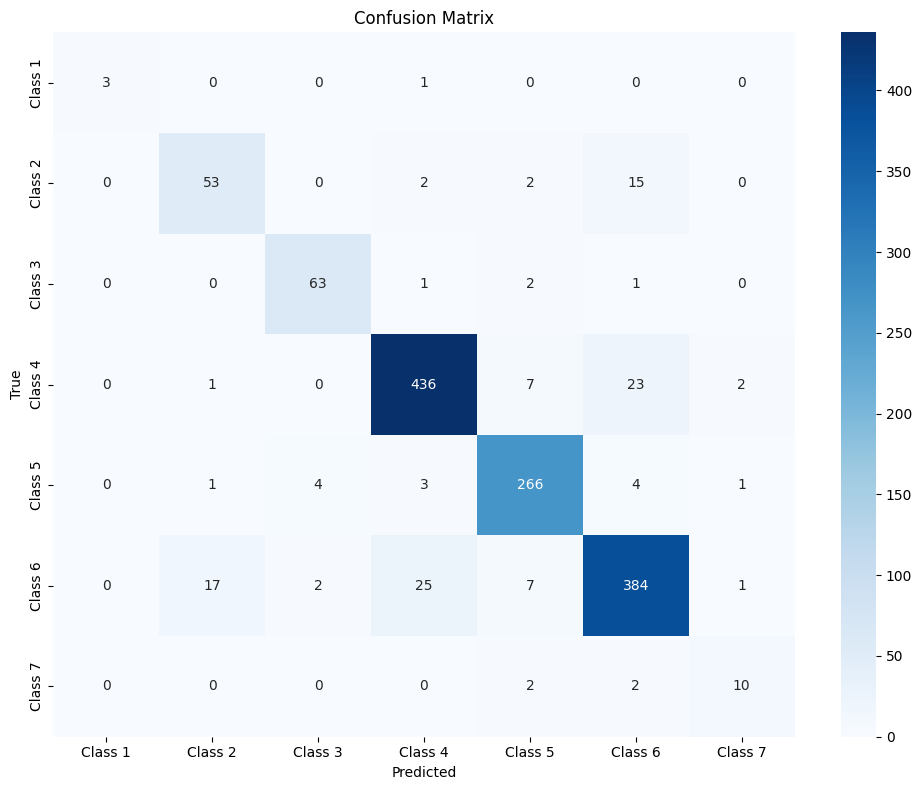

In [17]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
from utils import WCTfidfVectorizer, TextPreprocessor, print_classification_report_matrix

lr_pipe = Pipeline([
    ('preprocessing', TextPreprocessor()),
    ('tfidf', WCTfidfVectorizer(total_features=1000)),
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('lr', LogisticRegression(random_state=42, C=10, solver='saga', penalty='l2', max_iter=300))
])

lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)

print_classification_report_matrix(y_test, y_pred)



In [64]:
import joblib

joblib.dump(lr_pipe, 'incident_classifier_lr_pipeline.pkl')
joblib.dump(svm_pipe, 'incident_classifier_svm_pipeline.pkl')


['incident_classifier_svm_pipeline.pkl']